# Model Selection Analysis: Dynamic vs RNASeq Features

## Analysis of Memory-Optimized Benchmark Results

This notebook analyzes the performance of machine learning models across different feature types (RNASeq, Dynamic, Combined) and networks (CDK4/6, FGFR4).

## Initialization and Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import ttest_ind

# Set up project path
path = os.getcwd()
index_project = path.find("project")
project_path = path[: index_project + 7]
os.chdir(project_path)
print(f"Project path set to: {os.getcwd()}")



Project path set to: c:\Github\ode-biomarker-project


In [2]:
from PathLoader import PathLoader
from DataLink import DataLink
# Initialize data access
path_loader = PathLoader("data_config.env", "current_user.env")
data_link = DataLink(path_loader, "data_codes.csv")

# Set up results directory
folder_name = "ThesisResult4-4-ModelSelectionGeneSubsets"
exp_id = "v1_mrmr_cdk46_fgfr4_genesubsets_seeds20_batch4"

main_folder = f"{path_loader.get_data_path()}data/results/{folder_name}"
exp_folder = f"{main_folder}/{exp_id}"
file_save_path = f"{exp_folder}/"

if not os.path.exists(main_folder):
    os.makedirs(main_folder)
if not os.path.exists(exp_folder):
    os.makedirs(exp_folder)

# Create print report
print_report_path = f"{file_save_path}feature_type_analysis_report_{exp_id}.md"
print_report_file = open(print_report_path, 'w', encoding='utf-8')

print_report_file.write(f"# Feature Type Analysis Report - {exp_id}\n\n")
print_report_file.write(f"**Generated**: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
print_report_file.write("Analysis focused on model performance comparison across feature types (RNASeq, Dynamic, Combined).\n\n")

def save_and_print(message, report_file=None, level="info"):
    """Save message to report file and print to console"""
    print(message)
    if report_file:
        if level == "header":
            report_file.write(f"# {message}\n\n")
        elif level == "section":
            report_file.write(f"## {message}\n\n")
        elif level == "subsection":
            report_file.write(f"### {message}\n\n")
        else:
            report_file.write(f"{message}\n\n")

## Data Loading and Validation

In [3]:
# Load benchmark results
pkl_path = f"{exp_folder}/model_selection_benchmark_{exp_id}.pkl"
if not os.path.exists(pkl_path):
    raise FileNotFoundError(f"Benchmark results not found: {pkl_path}")

df_benchmark = pd.read_pickle(pkl_path)
save_and_print(f"Loaded benchmark data with shape: {df_benchmark.shape}", print_report_file, level="section")

# Filter data to only include model_performance between 0 and 1 (fix outliers)
original_size = len(df_benchmark)
if "model_performance" in df_benchmark.columns:
    df_benchmark = df_benchmark[
        (df_benchmark["model_performance"] >= 0) & (df_benchmark["model_performance"] <= 1)
    ]
    filtered_size = len(df_benchmark)
    save_and_print(f"Filtered data from {original_size} to {filtered_size} rows (removed {original_size - filtered_size} outliers)", print_report_file, level="info")

# Fix incomplete model_name column by parsing from condition column
save_and_print("## Fixing Model Name Column", print_report_file, level="section")
save_and_print("Updating model_name column with complete model configuration from condition column", print_report_file, level="info")

def parse_model_name_from_condition(condition):
    """Parse complete model name from condition column format"""
    # Expected format: {model_config}_k{value}_{method}_{network}_{dataset_type}
    # Example: RandomForestRegressor_config1_k500_mrmr_cdk46_rnaseq
    parts = condition.split('_')
    
    # The model name is everything before the k-value part
    model_parts = []
    for part in parts:
        if part.startswith('k'):
            # Found k-value part, stop collecting model parts
            break
        model_parts.append(part)
    
    # Join model parts to get complete model name
    complete_model_name = '_'.join(model_parts)
    return complete_model_name

# Update the model_name column with parsed values
if 'condition' in df_benchmark.columns and 'model_name' in df_benchmark.columns:
    original_models = df_benchmark['model_name'].unique().tolist()
    df_benchmark['model_name'] = df_benchmark['condition'].apply(parse_model_name_from_condition)
    updated_models = df_benchmark['model_name'].unique().tolist()
    
    save_and_print("Model name update results:", print_report_file, level="subsection")
    save_and_print(f"Original model names: {sorted(original_models)}", print_report_file, level="info")
    save_and_print(f"Updated model names: {sorted(updated_models)}", print_report_file, level="info")

# Display basic information
save_and_print("Dataset Overview:", print_report_file, level="subsection")
save_and_print(f"Total runs: {len(df_benchmark)}", print_report_file, level="info")
save_and_print(f"Columns: {list(df_benchmark.columns)}", print_report_file, level="info")

# Display first rows
try:
    from IPython.display import display
    display(df_benchmark.head())
except Exception:
    save_and_print(df_benchmark.head().to_string(), print_report_file, level="info")

Loaded benchmark data with shape: (840, 19)
Filtered data from 840 to 354 rows (removed 486 outliers)
## Fixing Model Name Column
Updating model_name column with complete model configuration from condition column
Model name update results:
Original model names: ['KNeighborsRegressor', 'LinearRegression', 'MLPRegressor', 'RandomForestRegressor', 'SVR']
Updated model names: ['KNeighborsRegressor', 'LinearRegression', 'MLPRegressor_config1', 'MLPRegressor_config2', 'RandomForestRegressor_config1', 'RandomForestRegressor_config2', 'SVR']
Dataset Overview:
Total runs: 354
Columns: ['rng', 'condition', 'feature_importance', 'feature_importance_from', 'model_performance', 'metrics', 'selected_features', 'model_name', 'selected_scores', 'k', 'y_pred', 'y_true_index', 'feature_selection_time', 'model_training_time', 'prediction_time', 'network_type', 'dataset_type', 'k_value', 'method']


,rng,condition,feature_importance,feature_importance_from,model_performance,metrics,selected_features,model_name,selected_scores,k,y_pred,y_true_index,feature_selection_time,model_training_time,prediction_time,network_type,dataset_type,k_value,method
0,15795,RandomForestRegressor_config1_k500_mrmr_cdk46_...,"([PIK3CG, CCNE1, CCND2, CCND1, RB1, MYC, IRS2,...",model,0.295377,"{'r2': 0.29537666033864585, 'pearson_r': 0.554...","[PIK3CG, CCNE1, CCND2, CCND1, RB1, MYC, IRS2, ...",RandomForestRegressor_config1,"[109.8653450692915, 553.589100301713, 302.7690...",39,"[4.3806902999999995, 4.302533529999998, 3.4703...","Index(['SIDM00237', 'SIDM00722', 'SIDM01096', ...",0.012827,2.289876,0.011864,cdk46,genesubset,500,k500
1,15795,RandomForestRegressor_config2_k500_mrmr_cdk46_...,"([PIK3CG, CCNE1, CCND2, CCND1, RB1, MYC, IRS2,...",model,0.264467,"{'r2': 0.26446708653091433, 'pearson_r': 0.525...","[PIK3CG, CCNE1, CCND2, CCND1, RB1, MYC, IRS2, ...",RandomForestRegressor_config2,"[109.8653450692915, 553.589100301713, 302.7690...",39,"[4.308518683103934, 3.971336797133877, 3.50263...","Index(['SIDM00237', 'SIDM00722', 'SIDM01096', ...",0.013379,0.835812,0.019668,cdk46,genesubset,500,k500
2,15795,LinearRegression_k500_mrmr_cdk46_genesubset,"([PIK3CG, CCNE1, CCND2, CCND1, RB1, MYC, IRS2,...",model,0.079485,"{'r2': 0.0794849304786287, 'pearson_r': 0.3720...","[PIK3CG, CCNE1, CCND2, CCND1, RB1, MYC, IRS2, ...",LinearRegression,"[109.8653450692915, 553.589100301713, 302.7690...",39,"[4.630268681108442, 3.4759386209961285, 3.4143...","Index(['SIDM00237', 'SIDM00722', 'SIDM01096', ...",0.014246,0.003535,0.001411,cdk46,genesubset,500,mrmr
3,15795,KNeighborsRegressor_k500_mrmr_cdk46_genesubset,"([PIK3CG, CCNE1, CCND2, CCND1, RB1, MYC, IRS2,...",model,0.325220,"{'r2': 0.325219807239837, 'pearson_r': 0.58717...","[PIK3CG, CCNE1, CCND2, CCND1, RB1, MYC, IRS2, ...",KNeighborsRegressor,"[109.8653450692915, 553.589100301713, 302.7690...",39,"[4.540970702573141, 4.030738699997559, 3.48237...","Index(['SIDM00237', 'SIDM00722', 'SIDM01096', ...",0.013425,0.001811,0.029529,cdk46,genesubset,500,mrmr
4,15795,SVR_k500_mrmr_cdk46_genesubset,"([PIK3CG, CCNE1, CCND2, CCND1, RB1, MYC, IRS2,...",model,0.018369,"{'r2': 0.018369164198127064, 'pearson_r': 0.31...","[PIK3CG, CCNE1, CCND2, CCND1, RB1, MYC, IRS2, ...",SVR,"[109.8653450692915, 553.589100301713, 302.7690...",39,"[4.654635277466625, 3.6652465546789323, 3.4097...","Index(['SIDM00237', 'SIDM00722', 'SIDM01096', ...",0.011577,0.140590,0.002765,cdk46,genesubset,500,mrmr


## Data Structure Analysis

In [4]:
# Verify and parse the dataset structure
def validate_and_parse_dataset(df):
    """Validate dataset structure and extract feature type information"""
    
    save_and_print("## Dataset Validation and Parsing", print_report_file, level="section")
    
    # Check required columns
    required_cols = ['condition', 'network_type', 'dataset_type', 'model_performance']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Extract unique values dynamically
    networks = df['network_type'].unique().tolist()
    feature_types = df['dataset_type'].unique().tolist()
    conditions = df['condition'].unique().tolist()
    
    save_and_print("### Dataset Configuration", print_report_file, level="subsection")
    save_and_print(f"Networks: {networks}", print_report_file, level="info")
    save_and_print(f"Feature Types: {feature_types}", print_report_file, level="info")
    save_and_print(f"Unique conditions: {len(conditions)}", print_report_file, level="info")
    
    return networks, feature_types, conditions

networks, feature_types, conditions = validate_and_parse_dataset(df_benchmark)

## Dataset Validation and Parsing
### Dataset Configuration
Networks: ['cdk46', 'fgfr4']
Feature Types: ['genesubset', 'dynamic', 'combined']
Unique conditions: 36


## Publication-Quality Visualization Setup

In [5]:
# Configure publication-quality styling with small figures and large fonts
publication_config = {
    'figure_size_small': (6, 4),      # Small figures for journals
    'figure_size_medium': (8, 5),     # Medium figures
    'figure_size_large': (10, 6),     # Large figures
    'font_sizes': {
        'title': 16,                  # Large titles
        'axis_label': 14,             # Large axis labels
        'tick': 12,                   # Large tick labels
        'value': 11,                  # Value labels
        'legend': 12                  # Legend labels
    },
    'dpi': 600                        # High resolution for journals
}

# Set global plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create consistent color mapping for feature types
feature_type_colors = {
    'genesubset': '#ef99b4',  # Blue for gene subset (replaces RNASeq)
    'dynamic': '#ff7f0e',     # Orange for Dynamic
    'combined': '#2ca02c'     # Green for Combined
}

# Create consistent color mapping for networks
network_colors = {
    'cdk46': '#1f77b4',       # Blue for CDK4/6
    'fgfr4': '#ff7f0e'        # Orange for FGFR4
}

# Create readable labels
feature_type_labels = {
    'genesubset': 'Gene Subsets',
    'dynamic': 'Dynamic Features', 
    'combined': 'Combined Features'
}

network_labels = {
    'cdk46': 'CDK4/6 Network',
    'fgfr4': 'FGFR4 Network'
}

# Model labels for better readability - updated to match parsed model names
def create_model_labels(model_names):
    """Create readable labels for model names with fallback"""
    label_mapping = {}
    for model_name in model_names:
        if 'RandomForestRegressor_config1' in model_name:
            label_mapping[model_name] = 'RF Config1 (100 trees)'
        elif 'RandomForestRegressor_config2' in model_name:
            label_mapping[model_name] = 'RF Config2 (200 trees)'
        elif 'LinearRegression' in model_name:
            label_mapping[model_name] = 'Linear Regression'
        elif 'KNeighborsRegressor' in model_name:
            label_mapping[model_name] = 'K-Neighbors'
        elif 'SVR' in model_name:
            label_mapping[model_name] = 'Support Vector'
        elif 'MLPRegressor_config1' in model_name:
            label_mapping[model_name] = 'MLP Config1 (50 neurons)'
        elif 'MLPRegressor_config2' in model_name:
            label_mapping[model_name] = 'MLP Config2 (100-50 neurons)'
        else:
            # Fallback for any unexpected model names
            label_mapping[model_name] = model_name.replace('_', ' ').title()
    return label_mapping

# Get actual model names from the dataframe and create dynamic labels
actual_model_names = df_benchmark['model_name'].unique().tolist() if 'model_name' in df_benchmark.columns else []
model_labels = create_model_labels(actual_model_names)

save_and_print("Visualization configuration set up for publication-quality figures", print_report_file, level="info")
save_and_print(f"Dynamic model labels created for: {sorted(actual_model_names)}", print_report_file, level="info")

# Store actual model names for use in plotting
available_model_names = list(model_labels.keys())

Visualization configuration set up for publication-quality figures
Dynamic model labels created for: ['KNeighborsRegressor', 'LinearRegression', 'MLPRegressor_config1', 'MLPRegressor_config2', 'RandomForestRegressor_config1', 'RandomForestRegressor_config2', 'SVR']


## Feature Type Performance Comparison

In [6]:
# Create main feature type comparison visualization
save_and_print("## Feature Type Performance Comparison", print_report_file, level="section")

# Calculate performance statistics by feature type
feature_type_stats = df_benchmark.groupby('dataset_type')['model_performance'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('median', 'median'),
    ('max', 'max')
]).round(4)

save_and_print("Performance Statistics by Feature Type:", print_report_file, level="subsection")
save_and_print(feature_type_stats.to_string(), print_report_file, level="info")

## Feature Type Performance Comparison
Performance Statistics by Feature Type:
              count    mean     std     min  median     max
dataset_type                                               
combined        109  0.1760  0.1244  0.0024  0.1411  0.4603
dynamic          84  0.1735  0.1124  0.0038  0.1690  0.4422
genesubset      161  0.1855  0.1321  0.0008  0.1602  0.4605


### Small Multi-Panel Feature Type Comparison

C:\Users\l8105\AppData\Local\Temp\ipykernel_592\1581858743.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=network_data, x='dataset_type', y='model_performance',
C:\Users\l8105\AppData\Local\Temp\ipykernel_592\1581858743.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([feature_type_labels[ft] for ft in feature_types],
C:\Users\l8105\AppData\Local\Temp\ipykernel_592\1581858743.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=network_data, x='dataset_type', y='model_performance',
C:\Users\l8105\AppData\Local\Temp\ipykernel_592\1581858743.py:25: UserWarning: set_tickl

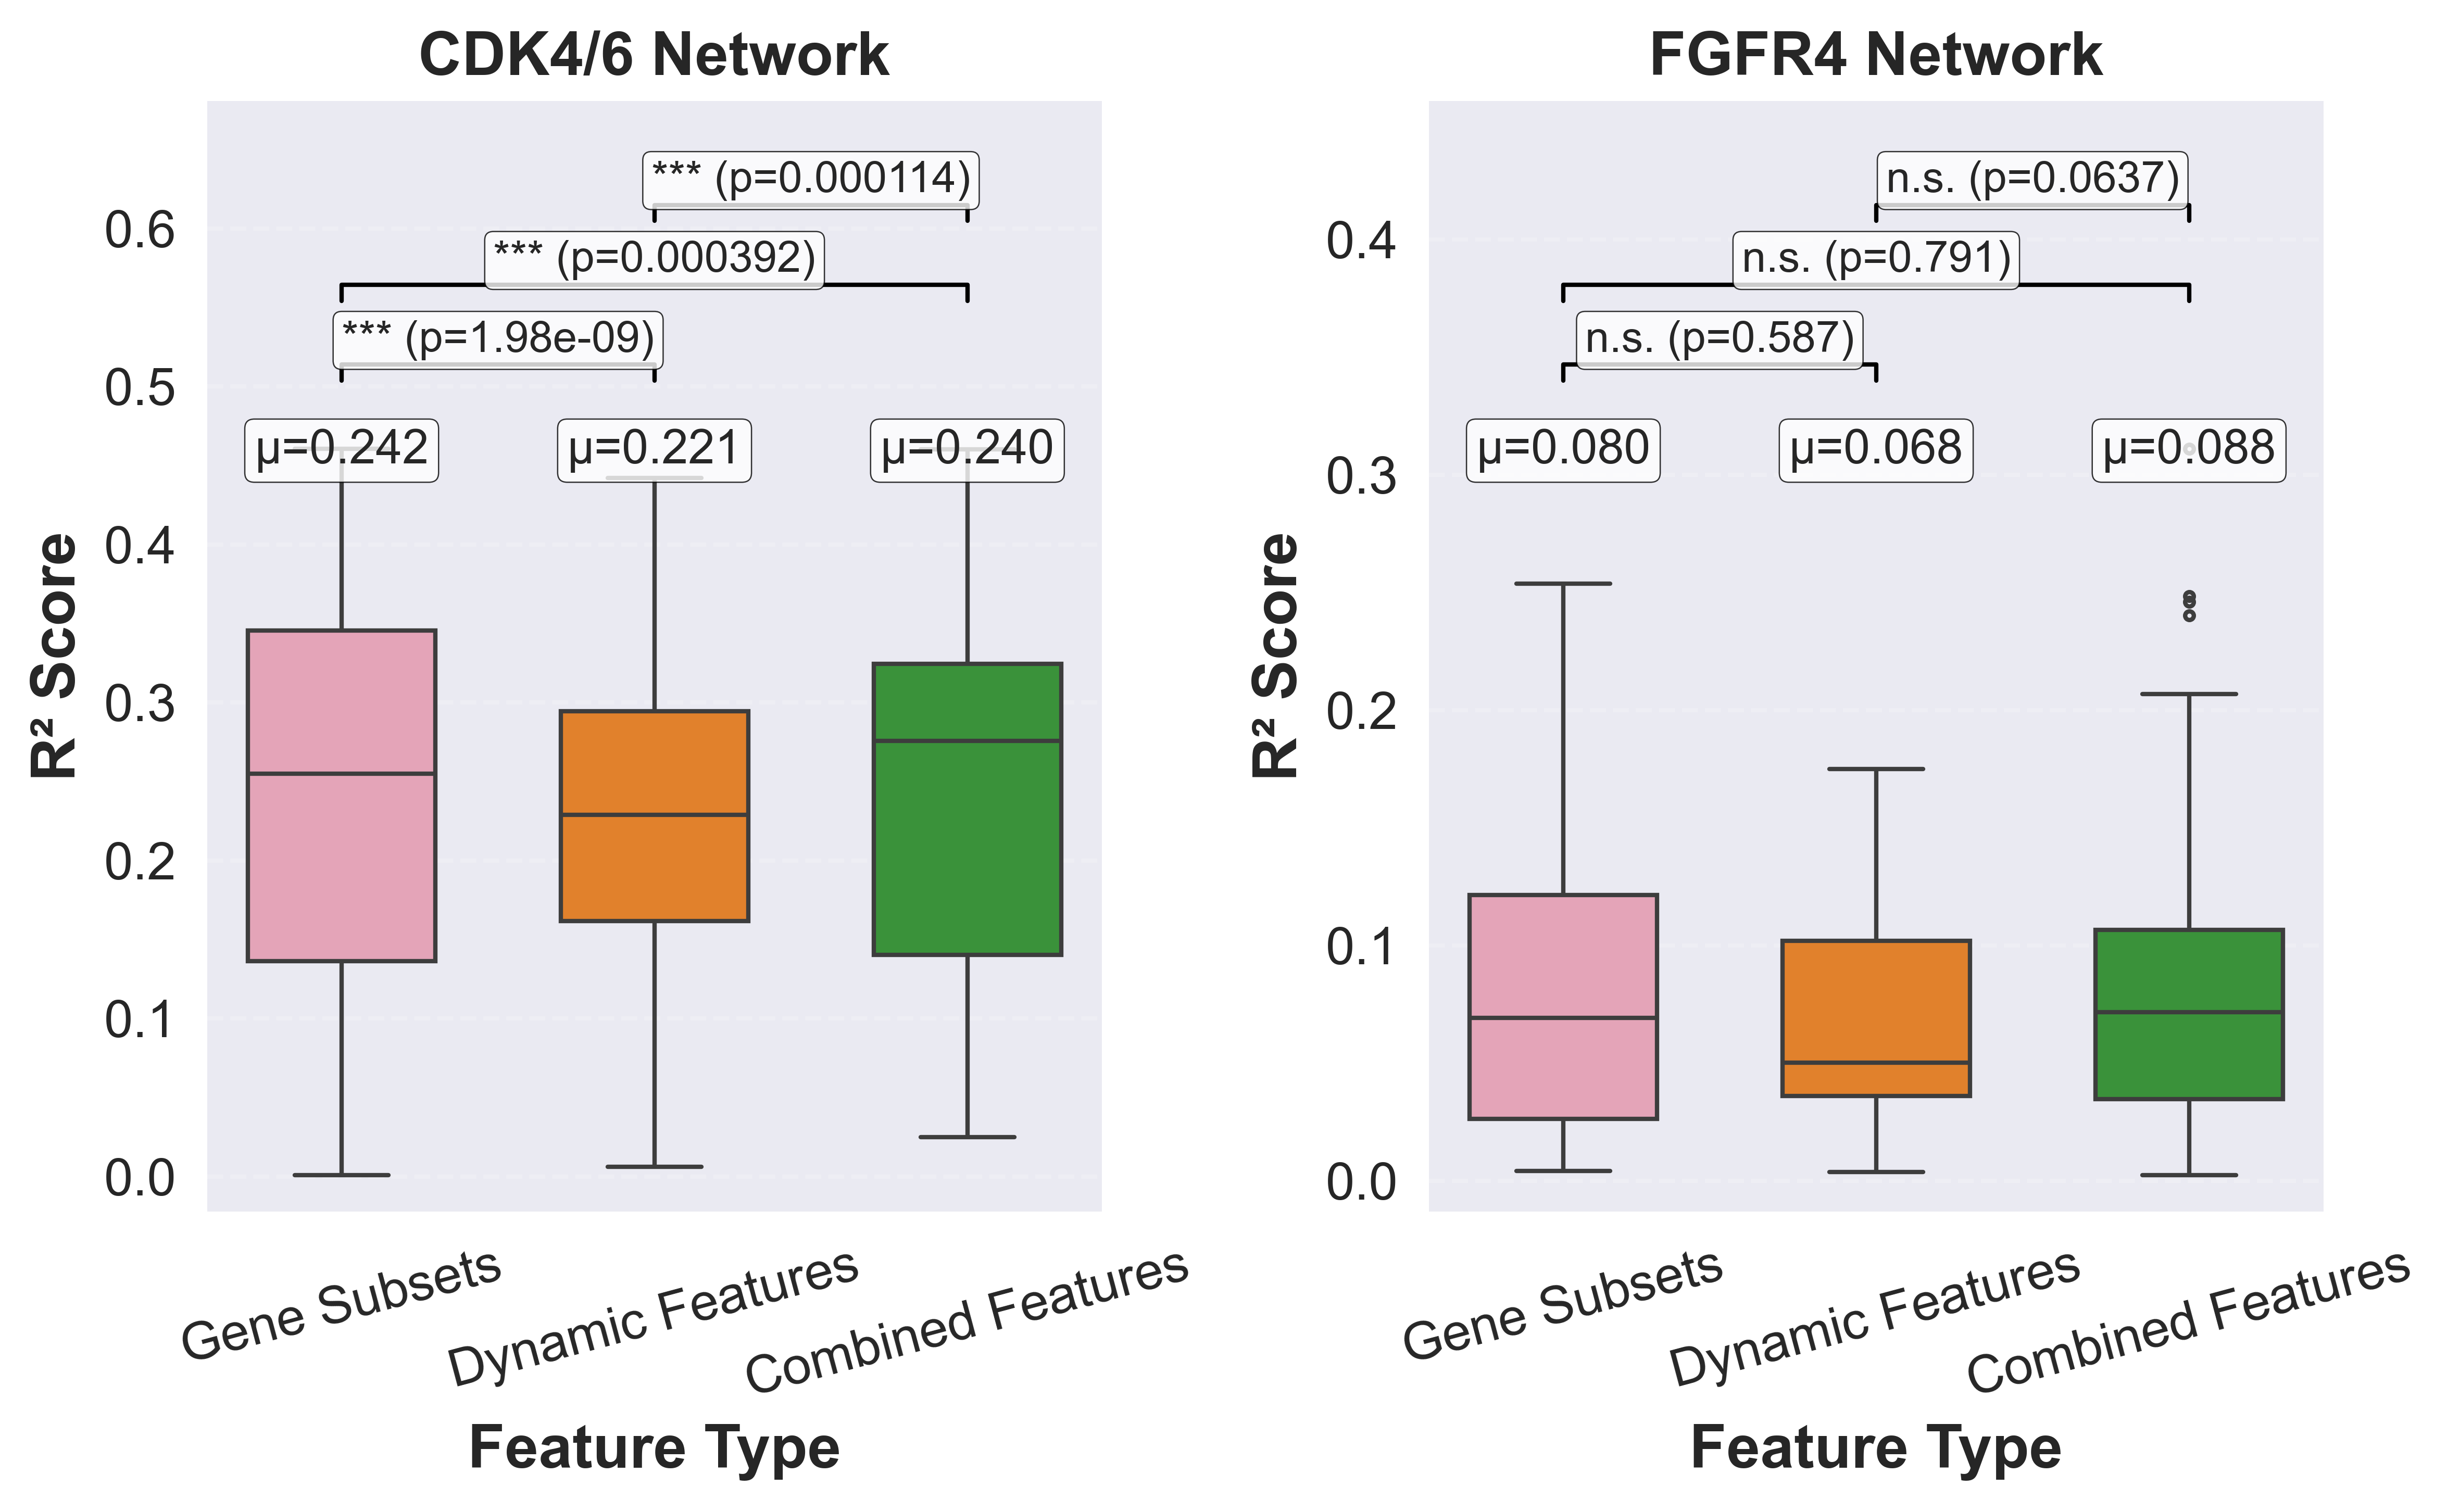

Created feature type comparison across networks plot


In [7]:
from scipy.stats import ttest_ind, ttest_rel

# Create small multi-panel plot comparing feature types across networks
fig, axes = plt.subplots(1, 2, figsize=publication_config['figure_size_medium'], dpi=publication_config['dpi'])

# Configure font sizes for all elements
plt.rcParams['font.size'] = publication_config['font_sizes']['tick']
plt.rcParams['axes.linewidth'] = 1.2

# Plot 1: Feature type comparison within each network
for i, network in enumerate(networks):
    ax = axes[i]
    network_data = df_benchmark[df_benchmark['network_type'] == network]
    
    # Create boxplot for feature type comparison
    sns.boxplot(data=network_data, x='dataset_type', y='model_performance',
                order=feature_types, palette=feature_type_colors,
                width=0.6, fliersize=2, ax=ax)
    
    ax.set_title(network_labels[network], fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
    ax.set_xlabel('Feature Type', fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
    ax.set_ylabel('R² Score', fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
    
    # Set x-tick labels with readable names
    ax.set_xticklabels([feature_type_labels[ft] for ft in feature_types], 
                       rotation=15, fontsize=publication_config['font_sizes']['tick'])
    
    ax.tick_params(axis='y', labelsize=publication_config['font_sizes']['tick'])
    ax.grid(axis='y', alpha=0.2, linestyle='--')
    
    # Add mean performance annotations
    for j, feature_type in enumerate(feature_types):
        subset = network_data[network_data['dataset_type'] == feature_type]
        if len(subset) > 0:
            mean_val = subset['model_performance'].mean()
            ylim = ax.get_ylim()
            y_pos = ylim[1] - 0.02 * (ylim[1] - ylim[0])  # position slightly below top relative to axis range
            ax.text(j, y_pos, f'μ={mean_val:.3f}', 
                    ha='center', va='top', fontsize=publication_config['font_sizes']['value'],
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))
    
    # Add pairwise significance annotations between feature types for this network

    # determine pairs to test
    pairs = []
    for a in range(len(feature_types)):
        for b in range(a + 1, len(feature_types)):
            pairs.append((a, b))

    # filter pairs that actually have data to test, to compute spacing
    valid_pairs = []
    for (a, b) in pairs:
        ft_a = feature_types[a]
        ft_b = feature_types[b]
        data_a = network_data[network_data['dataset_type'] == ft_a]['model_performance']
        data_b = network_data[network_data['dataset_type'] == ft_b]['model_performance']
        if len(data_a) > 0 and len(data_b) > 0:
            valid_pairs.append((a, b))

    if len(valid_pairs) > 0:
        # base coordinates and spacing for annotation lines (increase spacing)
        ylim = ax.get_ylim()
        yrange = ylim[1] - ylim[0] if (ylim[1] - ylim[0]) != 0 else 1.0
        y_base = ylim[1] + 0.04 * yrange  # start a bit higher above the top
        step = 0.10 * yrange              # larger step to reduce crowding
        small_cap = 0.02 * yrange         # cap height for the little vertical ticks

        annot_level = 0
        for (a, b) in valid_pairs:
            ft_a = feature_types[a]
            ft_b = feature_types[b]

            data_a = network_data[network_data['dataset_type'] == ft_a]['model_performance']
            data_b = network_data[network_data['dataset_type'] == ft_b]['model_performance']

            # attempt a paired t-test when samples can be matched (e.g. same rng & model_name);
            # otherwise fall back to Welch's t-test
            df_a = network_data[network_data['dataset_type'] == ft_a][['rng', 'model_name', 'model_performance']].set_index(['rng', 'model_name'])
            df_b = network_data[network_data['dataset_type'] == ft_b][['rng', 'model_name', 'model_performance']].set_index(['rng', 'model_name'])
            common_idx = df_a.index.intersection(df_b.index)

            if len(common_idx) > 1:
                # use paired test on matched samples
                data_a_paired = df_a.loc[common_idx]['model_performance']
                data_b_paired = df_b.loc[common_idx]['model_performance']
                t_stat, p_val = ttest_rel(data_a_paired, data_b_paired)
            else:
                # not enough paired observations -> use Welch's t-test on available samples
                t_stat, p_val = ttest_ind(data_a, data_b, equal_var=False)

            # convert p-value to significance string
            if p_val < 0.001:
                sig = '***'
            elif p_val < 0.01:
                sig = '**'
            elif p_val < 0.05:
                sig = '*'
            else:
                sig = 'n.s.'

            # compute y positions for the connecting line and text
            y = y_base + annot_level * step
            line_y = [y, y + small_cap, y + small_cap, y]

            # draw connector
            ax.plot([a, a, b, b], line_y, lw=1.0, c='black')
            # place significance text centered between groups
            x_text = (a + b) / 2.0
            ax.text(x_text, y + small_cap + 0.005 * yrange, f'{sig} (p={p_val:.3g})',
                    ha='center', va='bottom', fontsize=max(6, publication_config['font_sizes']['value'] - 1),
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

            annot_level += 1

        # expand y-limits so annotations are visible
        new_top = y_base + (annot_level + 0.5) * step
        ax.set_ylim(ylim[0], new_top)

plt.tight_layout()
plt.savefig(f"{file_save_path}feature_type_network_comparison_{exp_id}.png", 
            dpi=publication_config['dpi'], bbox_inches='tight')
plt.show()

save_and_print("Created feature type comparison across networks plot", print_report_file, level="info")

### Statistical Comparison Between Feature Types

In [8]:
# Perform statistical comparisons between feature types
save_and_print("### Statistical Comparison Between Feature Types", print_report_file, level="subsection")

feature_type_comparisons = []
for i, type1 in enumerate(feature_types):
    for j, type2 in enumerate(feature_types):
        if i < j:
            type1_data = df_benchmark[df_benchmark['dataset_type'] == type1]['model_performance']
            type2_data = df_benchmark[df_benchmark['dataset_type'] == type2]['model_performance']
            
            if len(type1_data) > 0 and len(type2_data) > 0:
                t_stat, p_value = ttest_ind(type1_data, type2_data, equal_var=False)
                mean_diff = type1_data.mean() - type2_data.mean()
                
                feature_type_comparisons.append({
                    'feature_type_1': type1,
                    'feature_type_2': type2,
                    'mean_difference': mean_diff,
                    't_statistic': t_stat,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                })

# Create comparison table
comparison_df = pd.DataFrame(feature_type_comparisons)
save_and_print("Statistical Comparisons Between Feature Types:", print_report_file, level="info")
save_and_print(comparison_df.round(4).to_string(index=False), print_report_file, level="info")

### Statistical Comparison Between Feature Types
Statistical Comparisons Between Feature Types:
feature_type_1 feature_type_2  mean_difference  t_statistic  p_value  significant
    genesubset        dynamic           0.0120       0.7456   0.4568        False
    genesubset       combined           0.0095       0.6021   0.5477        False
       dynamic       combined          -0.0025      -0.1442   0.8855        False


## Model Performance Heatmap by Feature Type

## Model Performance Heatmap Analysis


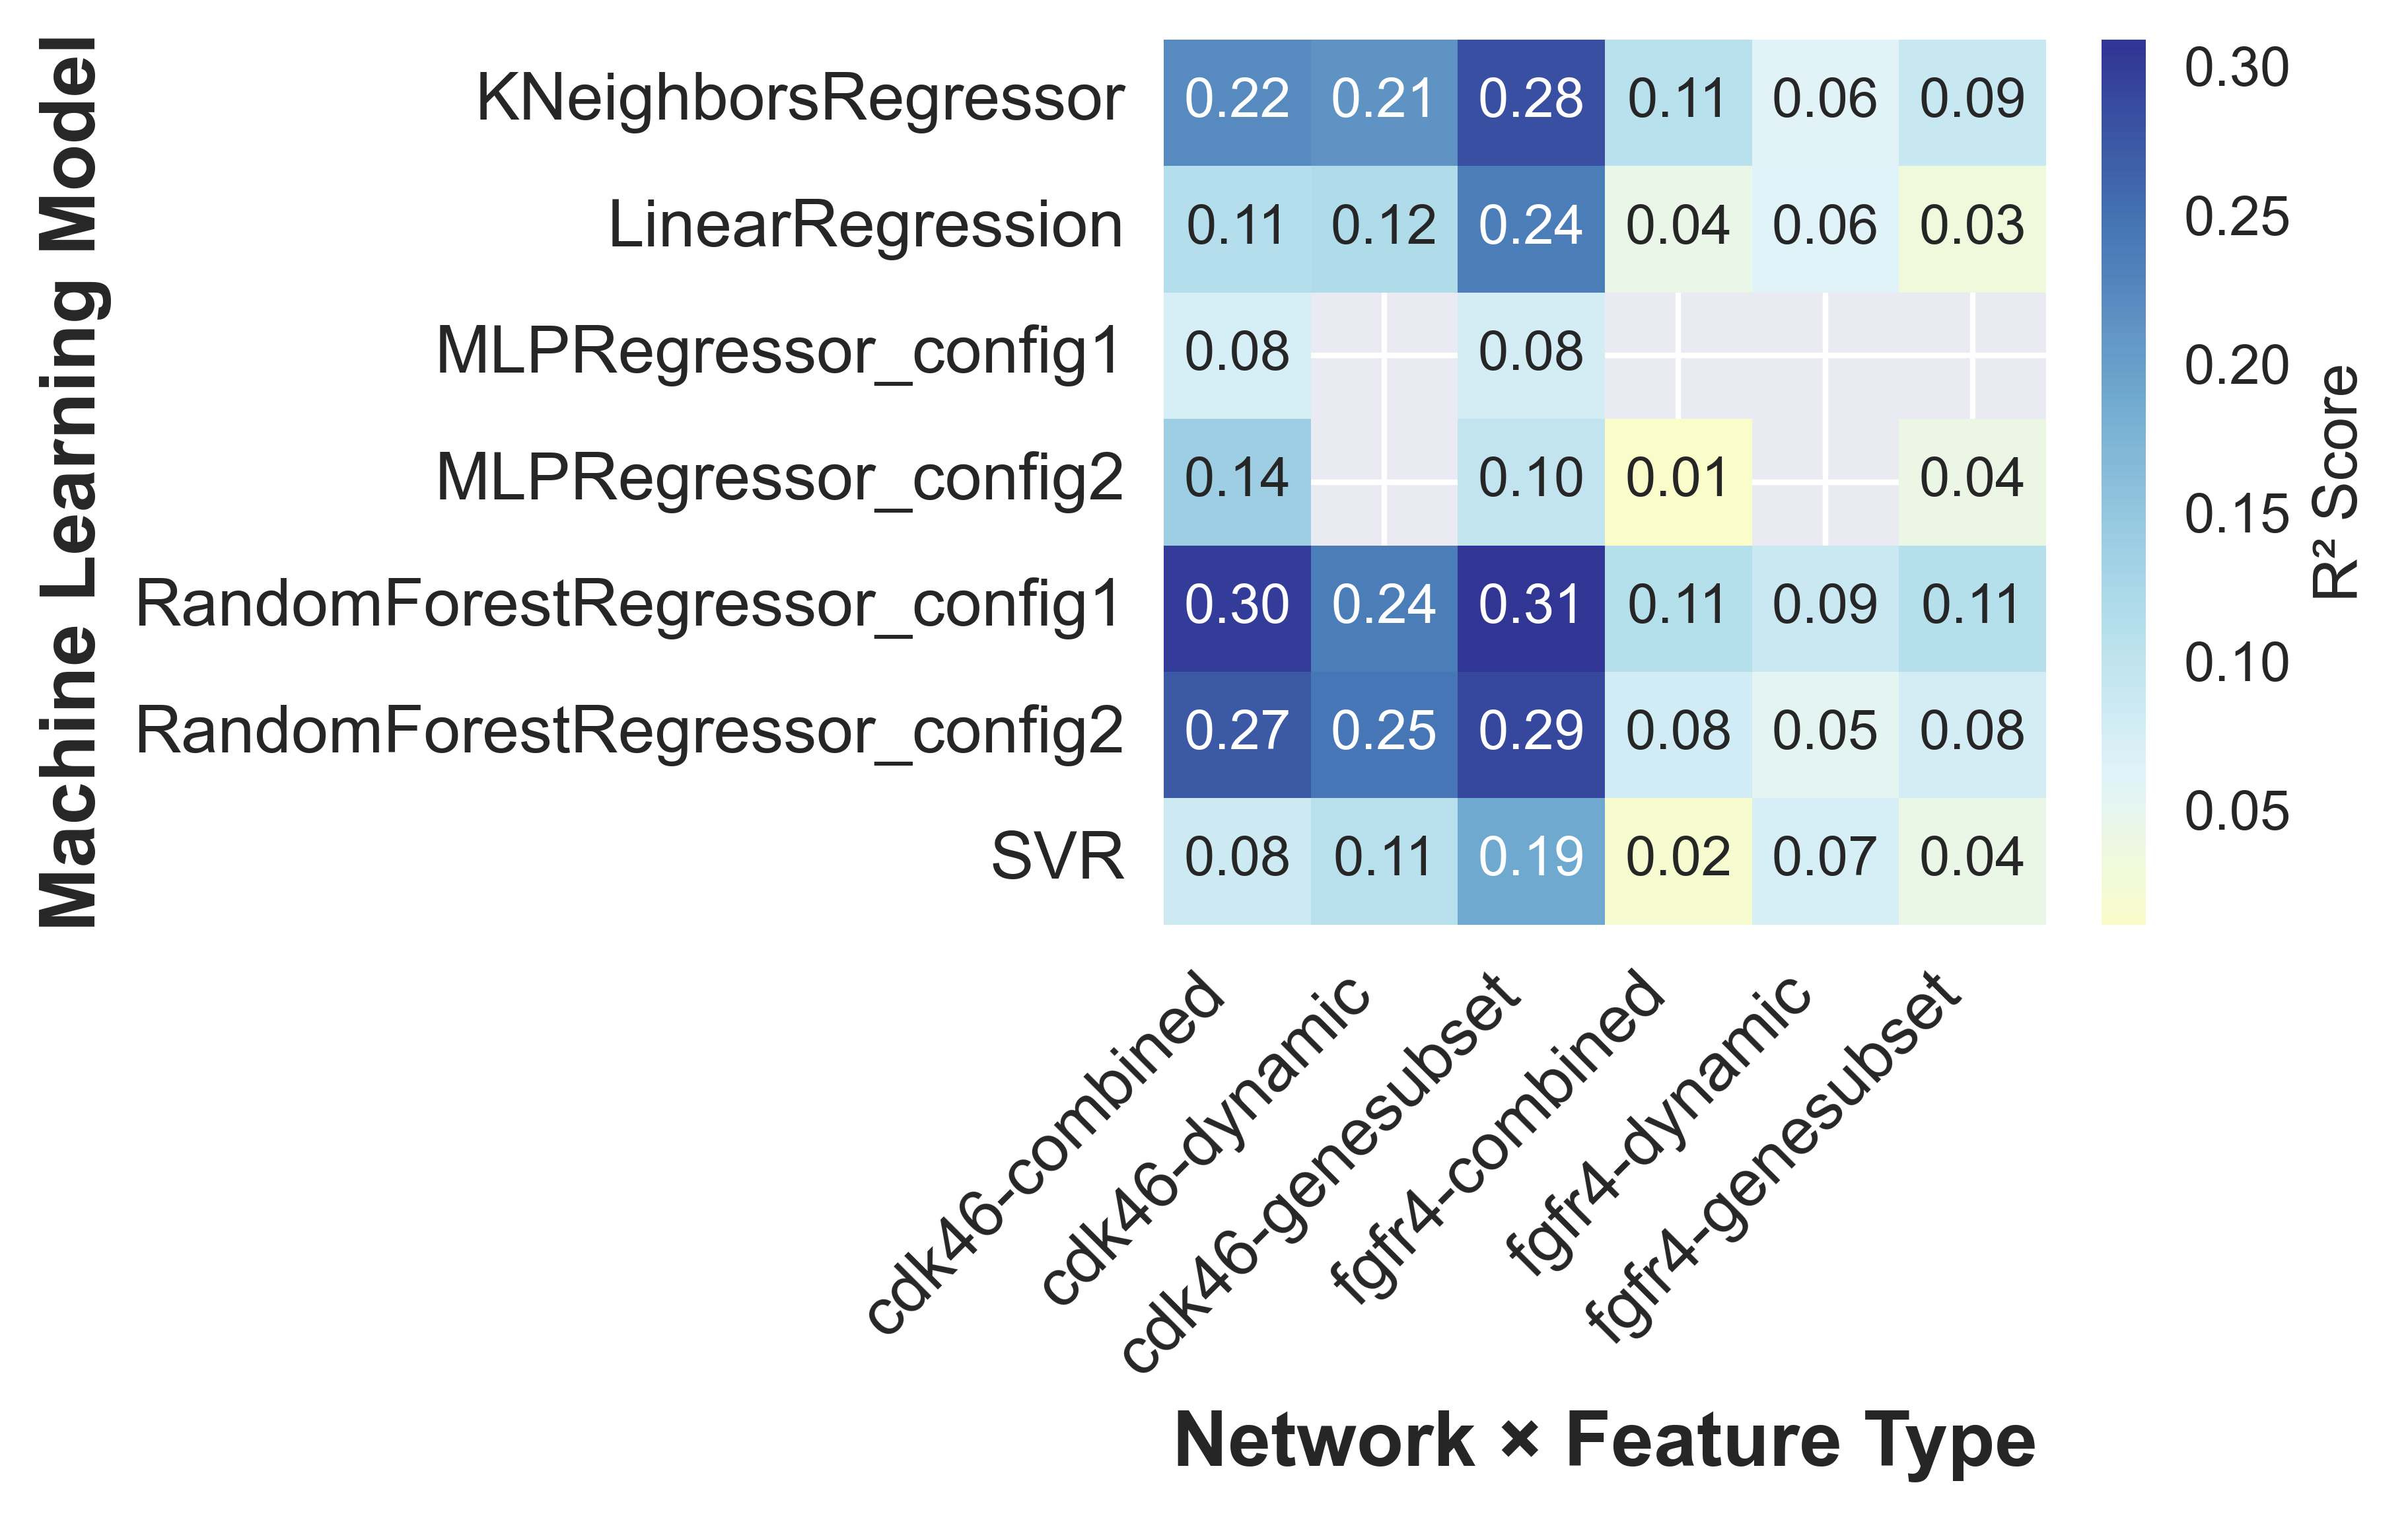

Created performance heatmap


In [9]:
# Create heatmap showing model performance across feature types and networks
save_and_print("## Model Performance Heatmap Analysis", print_report_file, level="section")

# Calculate mean performance for each model × feature type × network combination
performance_matrix = df_benchmark.groupby(['model_name', 'dataset_type', 'network_type'])['model_performance'].mean().unstack().unstack()

# Create heatmap with optimized sizing
plt.figure(figsize=publication_config['figure_size_small'], dpi=publication_config['dpi'])
plt.rcParams['font.size'] = publication_config['font_sizes']['tick']

# Create the heatmap
sns.heatmap(performance_matrix, annot=True, fmt='.2f', cmap='RdYlBu', 
            center=0, cbar_kws={'label': 'R² Score'},
            annot_kws={'size': 10})

plt.xlabel('Network × Feature Type', fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
plt.ylabel('Machine Learning Model', fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')

# Adjust tick labels for readability
plt.xticks(rotation=45, ha='right', fontsize=publication_config['font_sizes']['tick'])
plt.yticks(fontsize=publication_config['font_sizes']['tick'])

plt.tight_layout()
plt.savefig(f"{file_save_path}performance_heatmap_{exp_id}.png", 
            dpi=publication_config['dpi'], bbox_inches='tight')
plt.show()

save_and_print("Created performance heatmap", print_report_file, level="info")

## Network-Specific Feature Type Analysis

## Network-Specific Feature Type Analysis


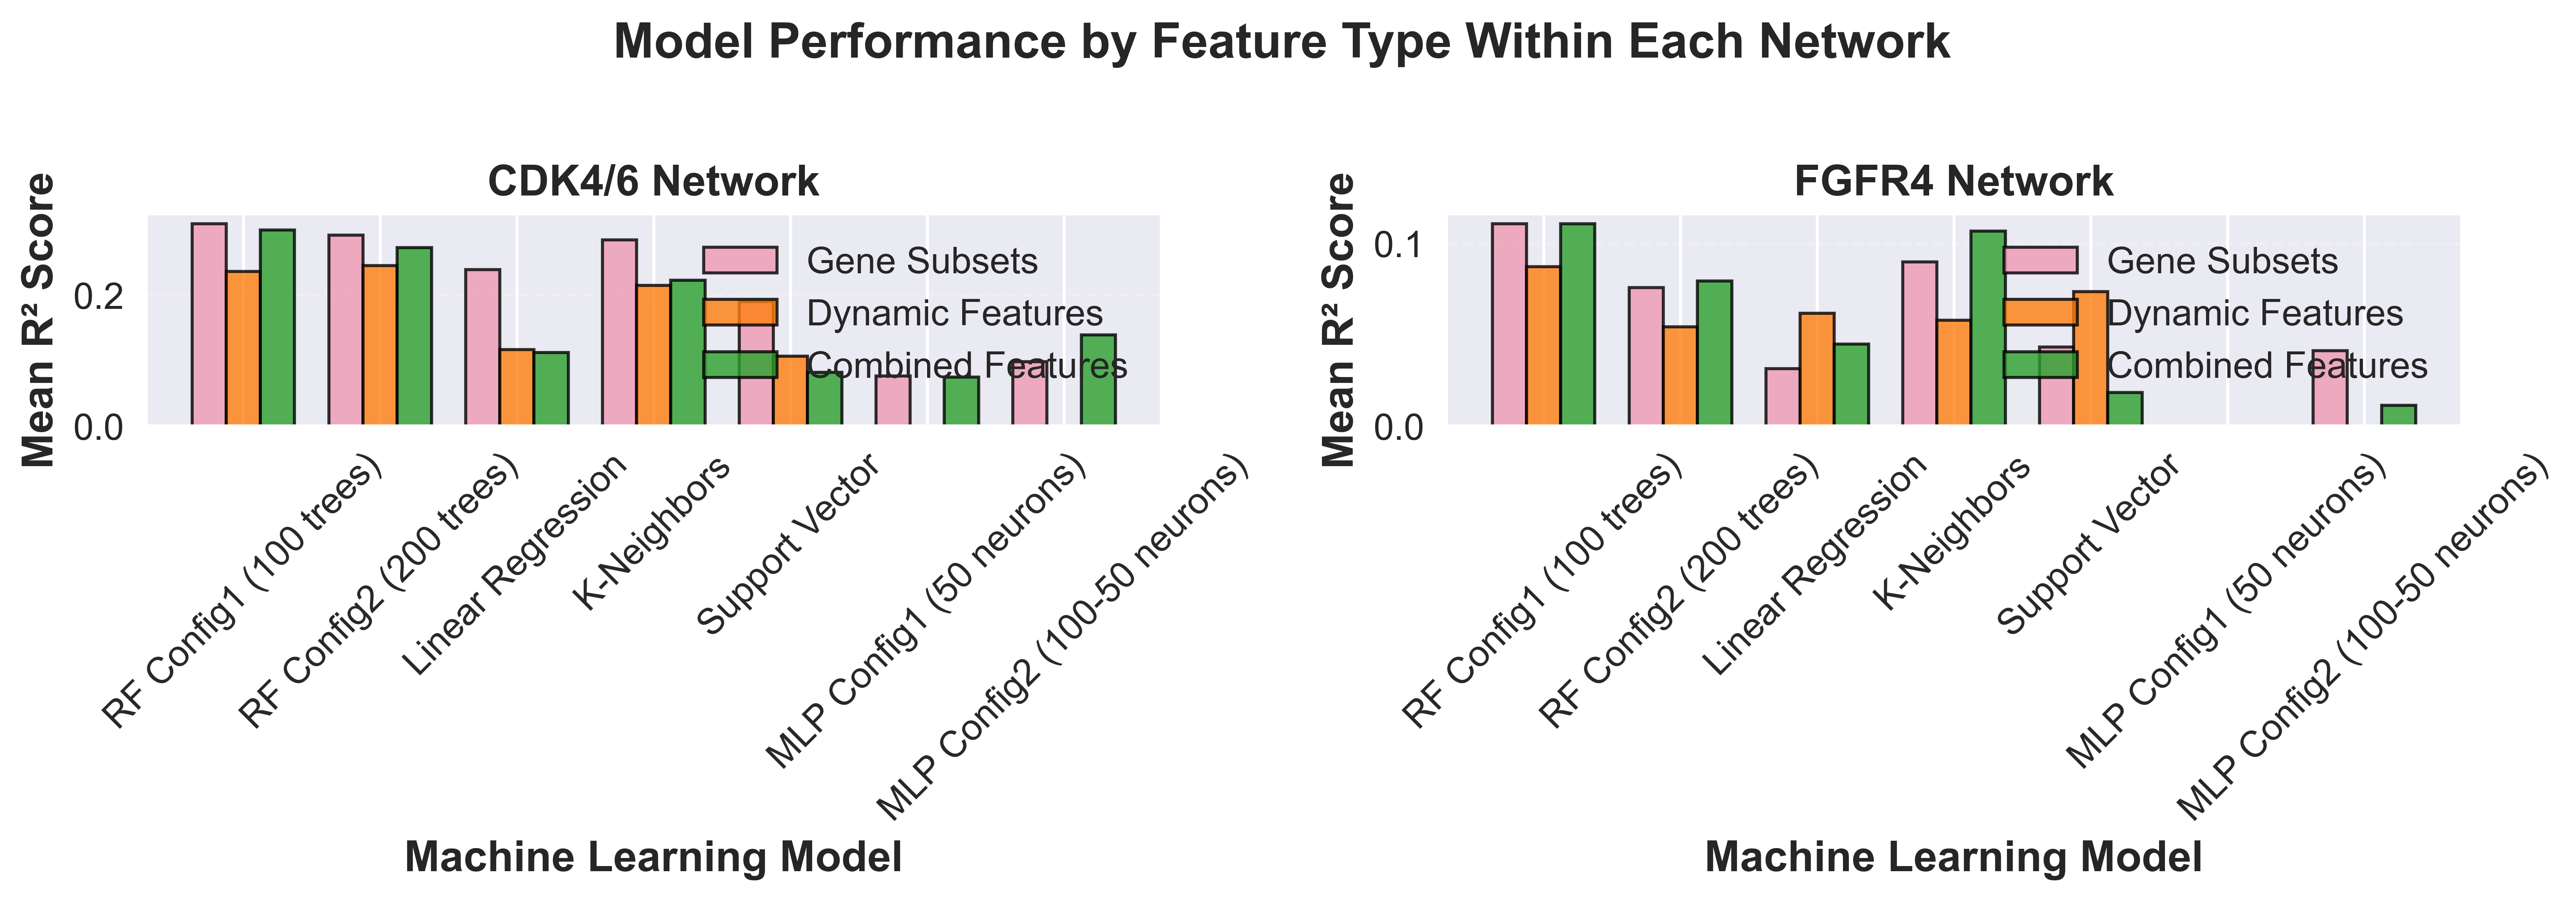

Created network-specific feature type analysis


In [10]:
# Create network-specific detailed analysis
save_and_print("## Network-Specific Feature Type Analysis", print_report_file, level="section")

# Calculate optimal subplot layout
n_networks = len(networks)
cols = min(2, n_networks)  # Max 2 columns for small figures
rows = (n_networks + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), dpi=publication_config['dpi'])
fig.suptitle('Model Performance by Feature Type Within Each Network', 
             fontsize=publication_config['font_sizes']['title'], fontweight='bold', y=1.02)

# Flatten axes for easier indexing
if rows == 1 and cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Plot each network separately
for i, network in enumerate(networks):
    if i < len(axes):
        ax = axes[i]
        network_data = df_benchmark[df_benchmark['network_type'] == network]
        
        # Calculate mean performance for each model and feature type
        network_stats = network_data.groupby(['model_name', 'dataset_type'])['model_performance'].agg(['mean', 'std', 'count']).reset_index()
        
        # Create grouped bar plot
        bar_width = 0.25
        x_pos = np.arange(len(model_labels))
        
        for j, feature_type in enumerate(feature_types):
            feature_data = network_stats[network_stats['dataset_type'] == feature_type]
            
            # Ensure data is in correct order
            means = []
            for model in model_labels.keys():
                model_data = feature_data[feature_data['model_name'] == model]
                if len(model_data) > 0:
                    means.append(model_data['mean'].iloc[0])
                else:
                    means.append(0)
            
            bars = ax.bar(x_pos + j * bar_width, means, bar_width,
                         color=feature_type_colors[feature_type], alpha=0.8,
                         edgecolor='black', linewidth=1,
                         label=feature_type_labels[feature_type])
        
        ax.set_title(network_labels[network], fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
        ax.set_xlabel('Machine Learning Model', fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
        ax.set_ylabel('Mean R² Score', fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
        ax.set_xticks(x_pos + bar_width)
        ax.set_xticklabels([model_labels[m] for m in model_labels.keys()], 
                          rotation=45, fontsize=publication_config['font_sizes']['tick'])
        ax.tick_params(axis='y', labelsize=publication_config['font_sizes']['tick'])
        ax.legend(fontsize=publication_config['font_sizes']['legend'], framealpha=0.9)
        ax.grid(axis='y', alpha=0.2, linestyle='--')

# Hide unused subplots
for i in range(len(networks), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig(f"{file_save_path}network_specific_analysis_{exp_id}.png", 
            dpi=publication_config['dpi'], bbox_inches='tight')
plt.show()

save_and_print("Created network-specific feature type analysis", print_report_file, level="info")

## Timing and Efficiency Analysis

## Computational Efficiency Analysis
Timing Statistics by Feature Type:
             feature_selection_time           model_training_time           prediction_time          
                               mean       std                mean       std            mean       std
dataset_type                                                                                         
combined                   0.333664  0.143172            2.905216  3.136072        0.010340  0.006151
dynamic                    0.251526  0.116209            2.093541  2.431932        0.010026  0.006003
genesubset                 0.011682  0.001432            0.852204  0.957424        0.007775  0.007372


C:\Users\l8105\AppData\Local\Temp\ipykernel_592\1441563914.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_benchmark, x='dataset_type', y='total_time',


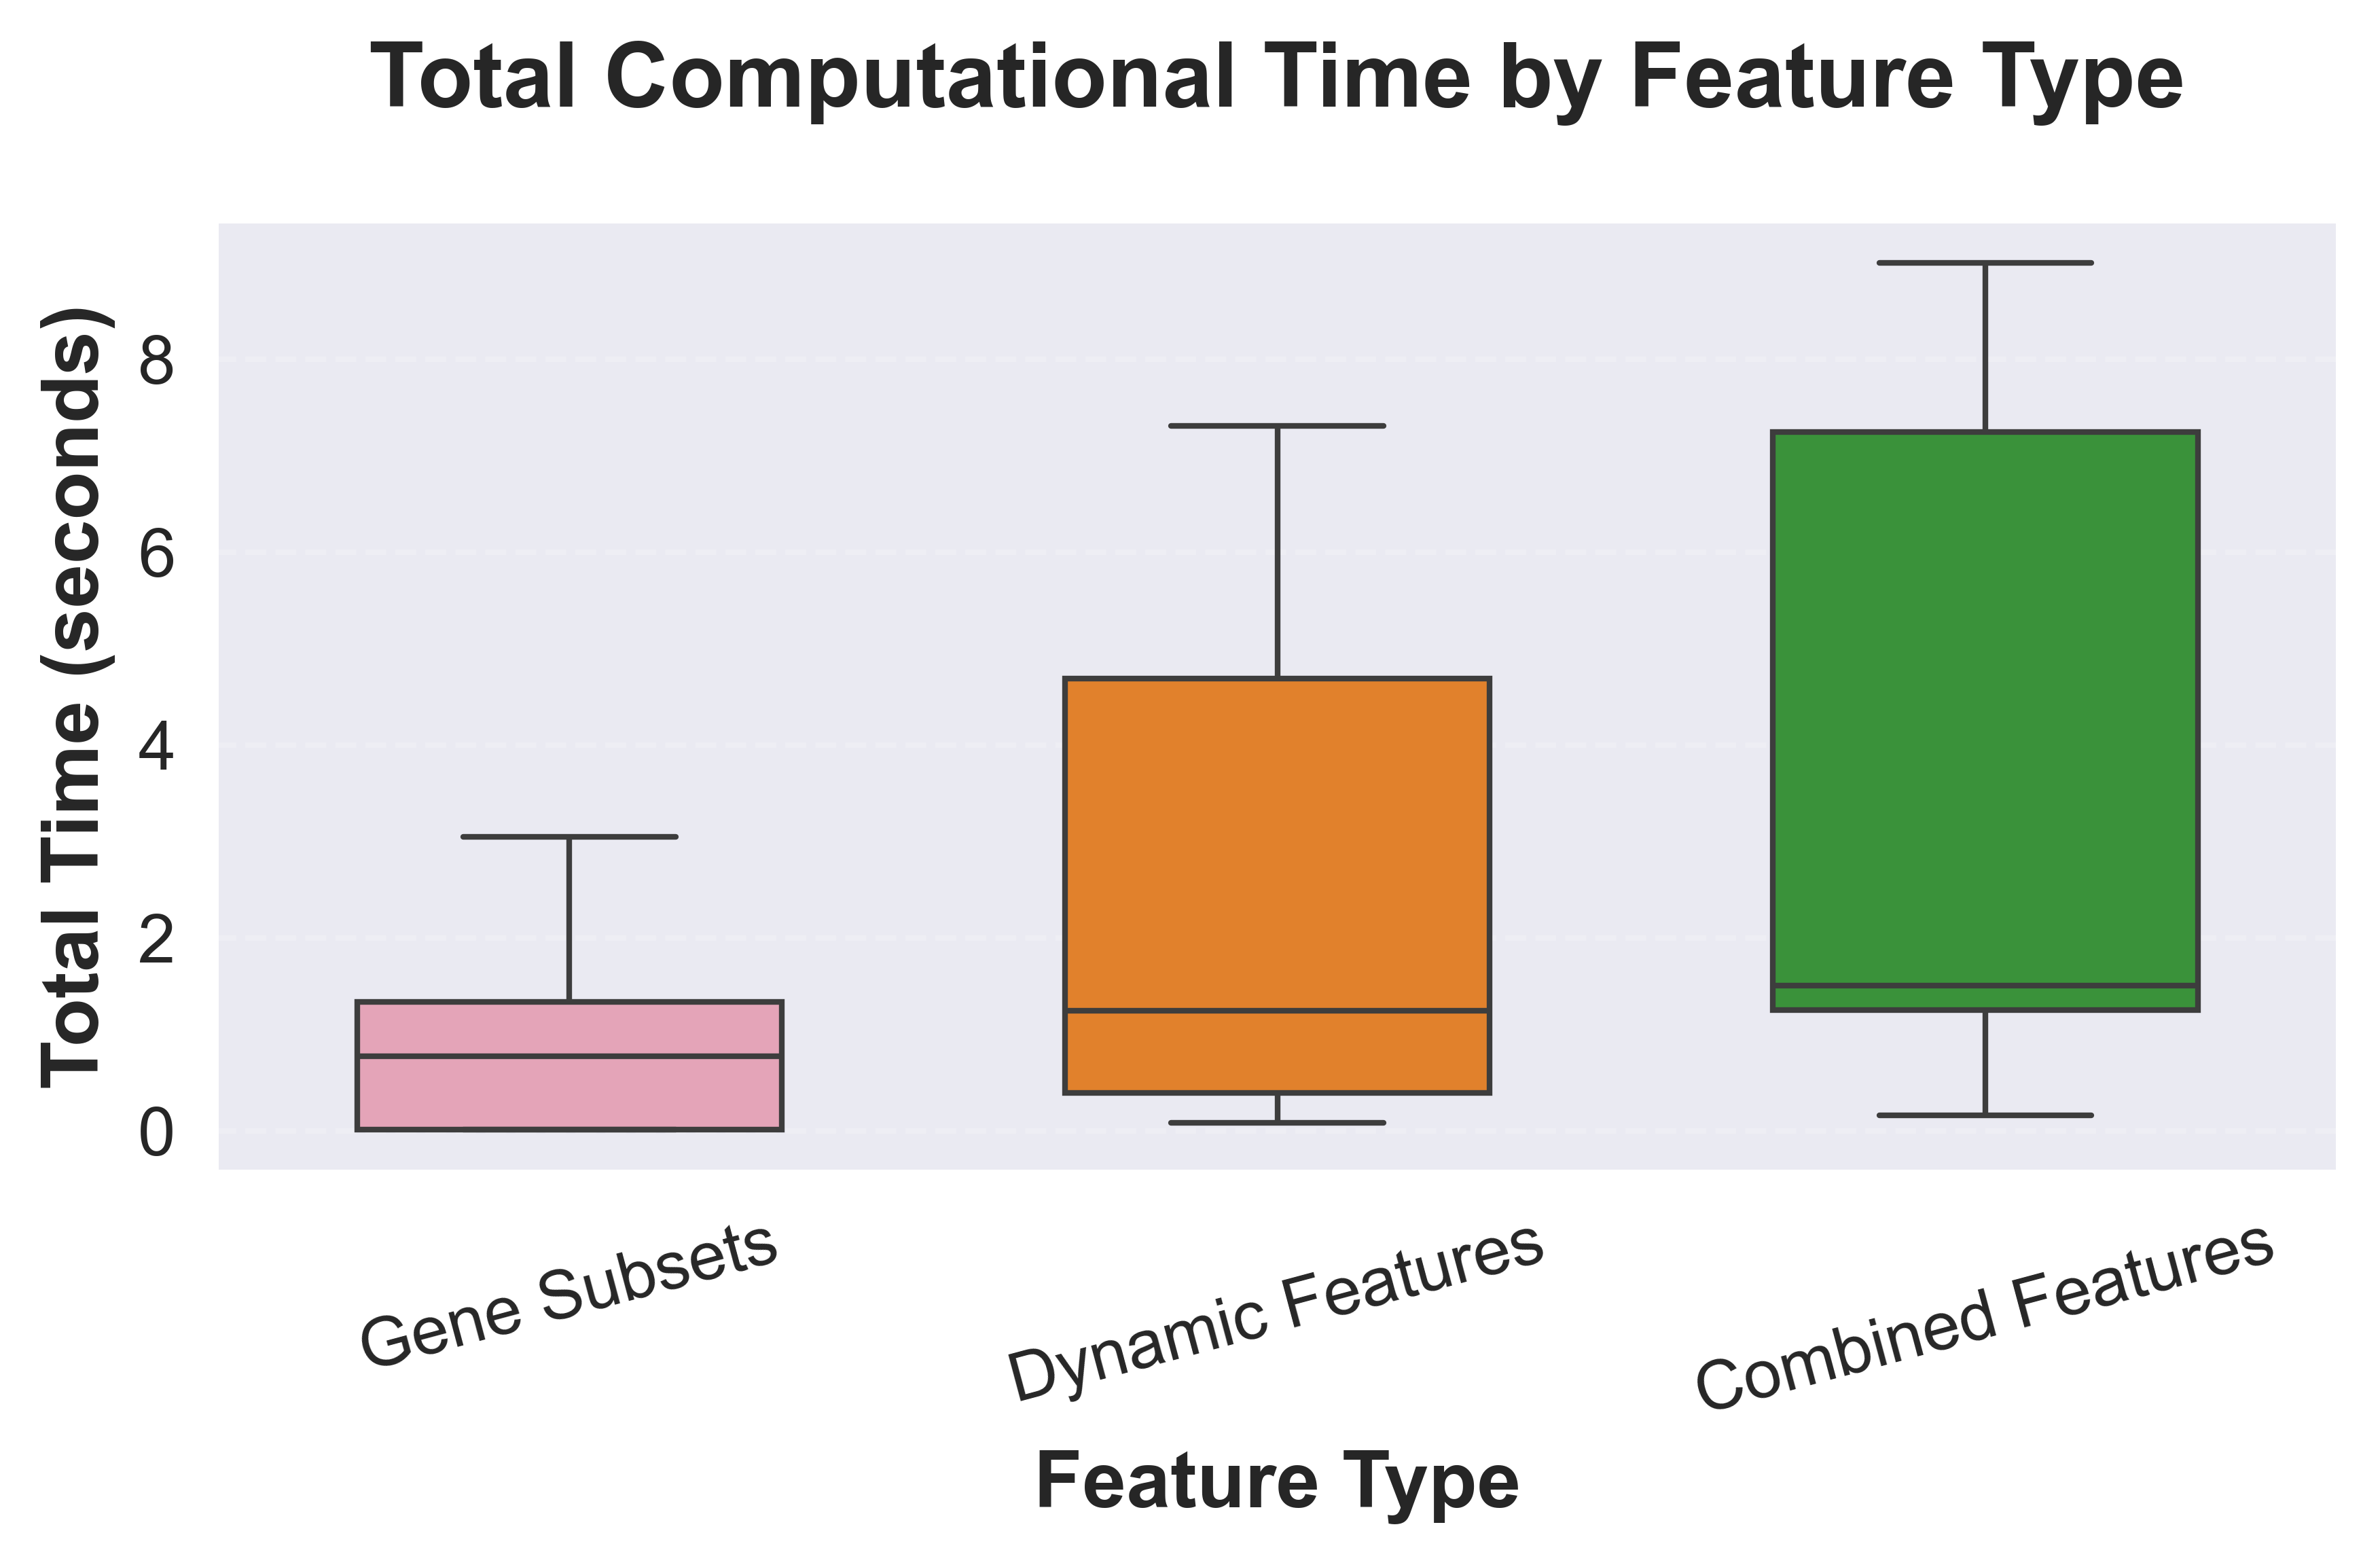

Created timing efficiency comparison


In [11]:
# Analyze computational efficiency across feature types
save_and_print("## Computational Efficiency Analysis", print_report_file, level="section")

# Calculate timing statistics by feature type
timing_stats = df_benchmark.groupby('dataset_type')[['feature_selection_time', 'model_training_time', 'prediction_time']].agg(['mean', 'std']).round(6)

save_and_print("Timing Statistics by Feature Type:", print_report_file, level="subsection")
save_and_print(timing_stats.to_string(), print_report_file, level="info")

# Create efficiency comparison plot
plt.figure(figsize=publication_config['figure_size_small'], dpi=publication_config['dpi'])
plt.rcParams['font.size'] = publication_config['font_sizes']['tick']

# Calculate total time (sum of all components)
df_benchmark['total_time'] = df_benchmark['feature_selection_time'] + df_benchmark['model_training_time'] + df_benchmark['prediction_time']

# Create boxplot of total time by feature type
sns.boxplot(data=df_benchmark, x='dataset_type', y='total_time',
            order=feature_types, palette=feature_type_colors,
            width=0.6, fliersize=2)

plt.title('Total Computational Time by Feature Type', 
          fontsize=publication_config['font_sizes']['title'], fontweight='bold', pad=20)
plt.xlabel('Feature Type', fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
plt.ylabel('Total Time (seconds)', fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
plt.xticks(ticks=range(len(feature_types)), 
           labels=[feature_type_labels[ft] for ft in feature_types],
           rotation=15, fontsize=publication_config['font_sizes']['tick'])
plt.yticks(fontsize=publication_config['font_sizes']['tick'])
plt.grid(axis='y', alpha=0.2, linestyle='--')

plt.tight_layout()
plt.savefig(f"{file_save_path}timing_efficiency_{exp_id}.png", 
            dpi=publication_config['dpi'], bbox_inches='tight')
plt.show()

save_and_print("Created timing efficiency comparison", print_report_file, level="info")

## Best Performing Models by Feature Type

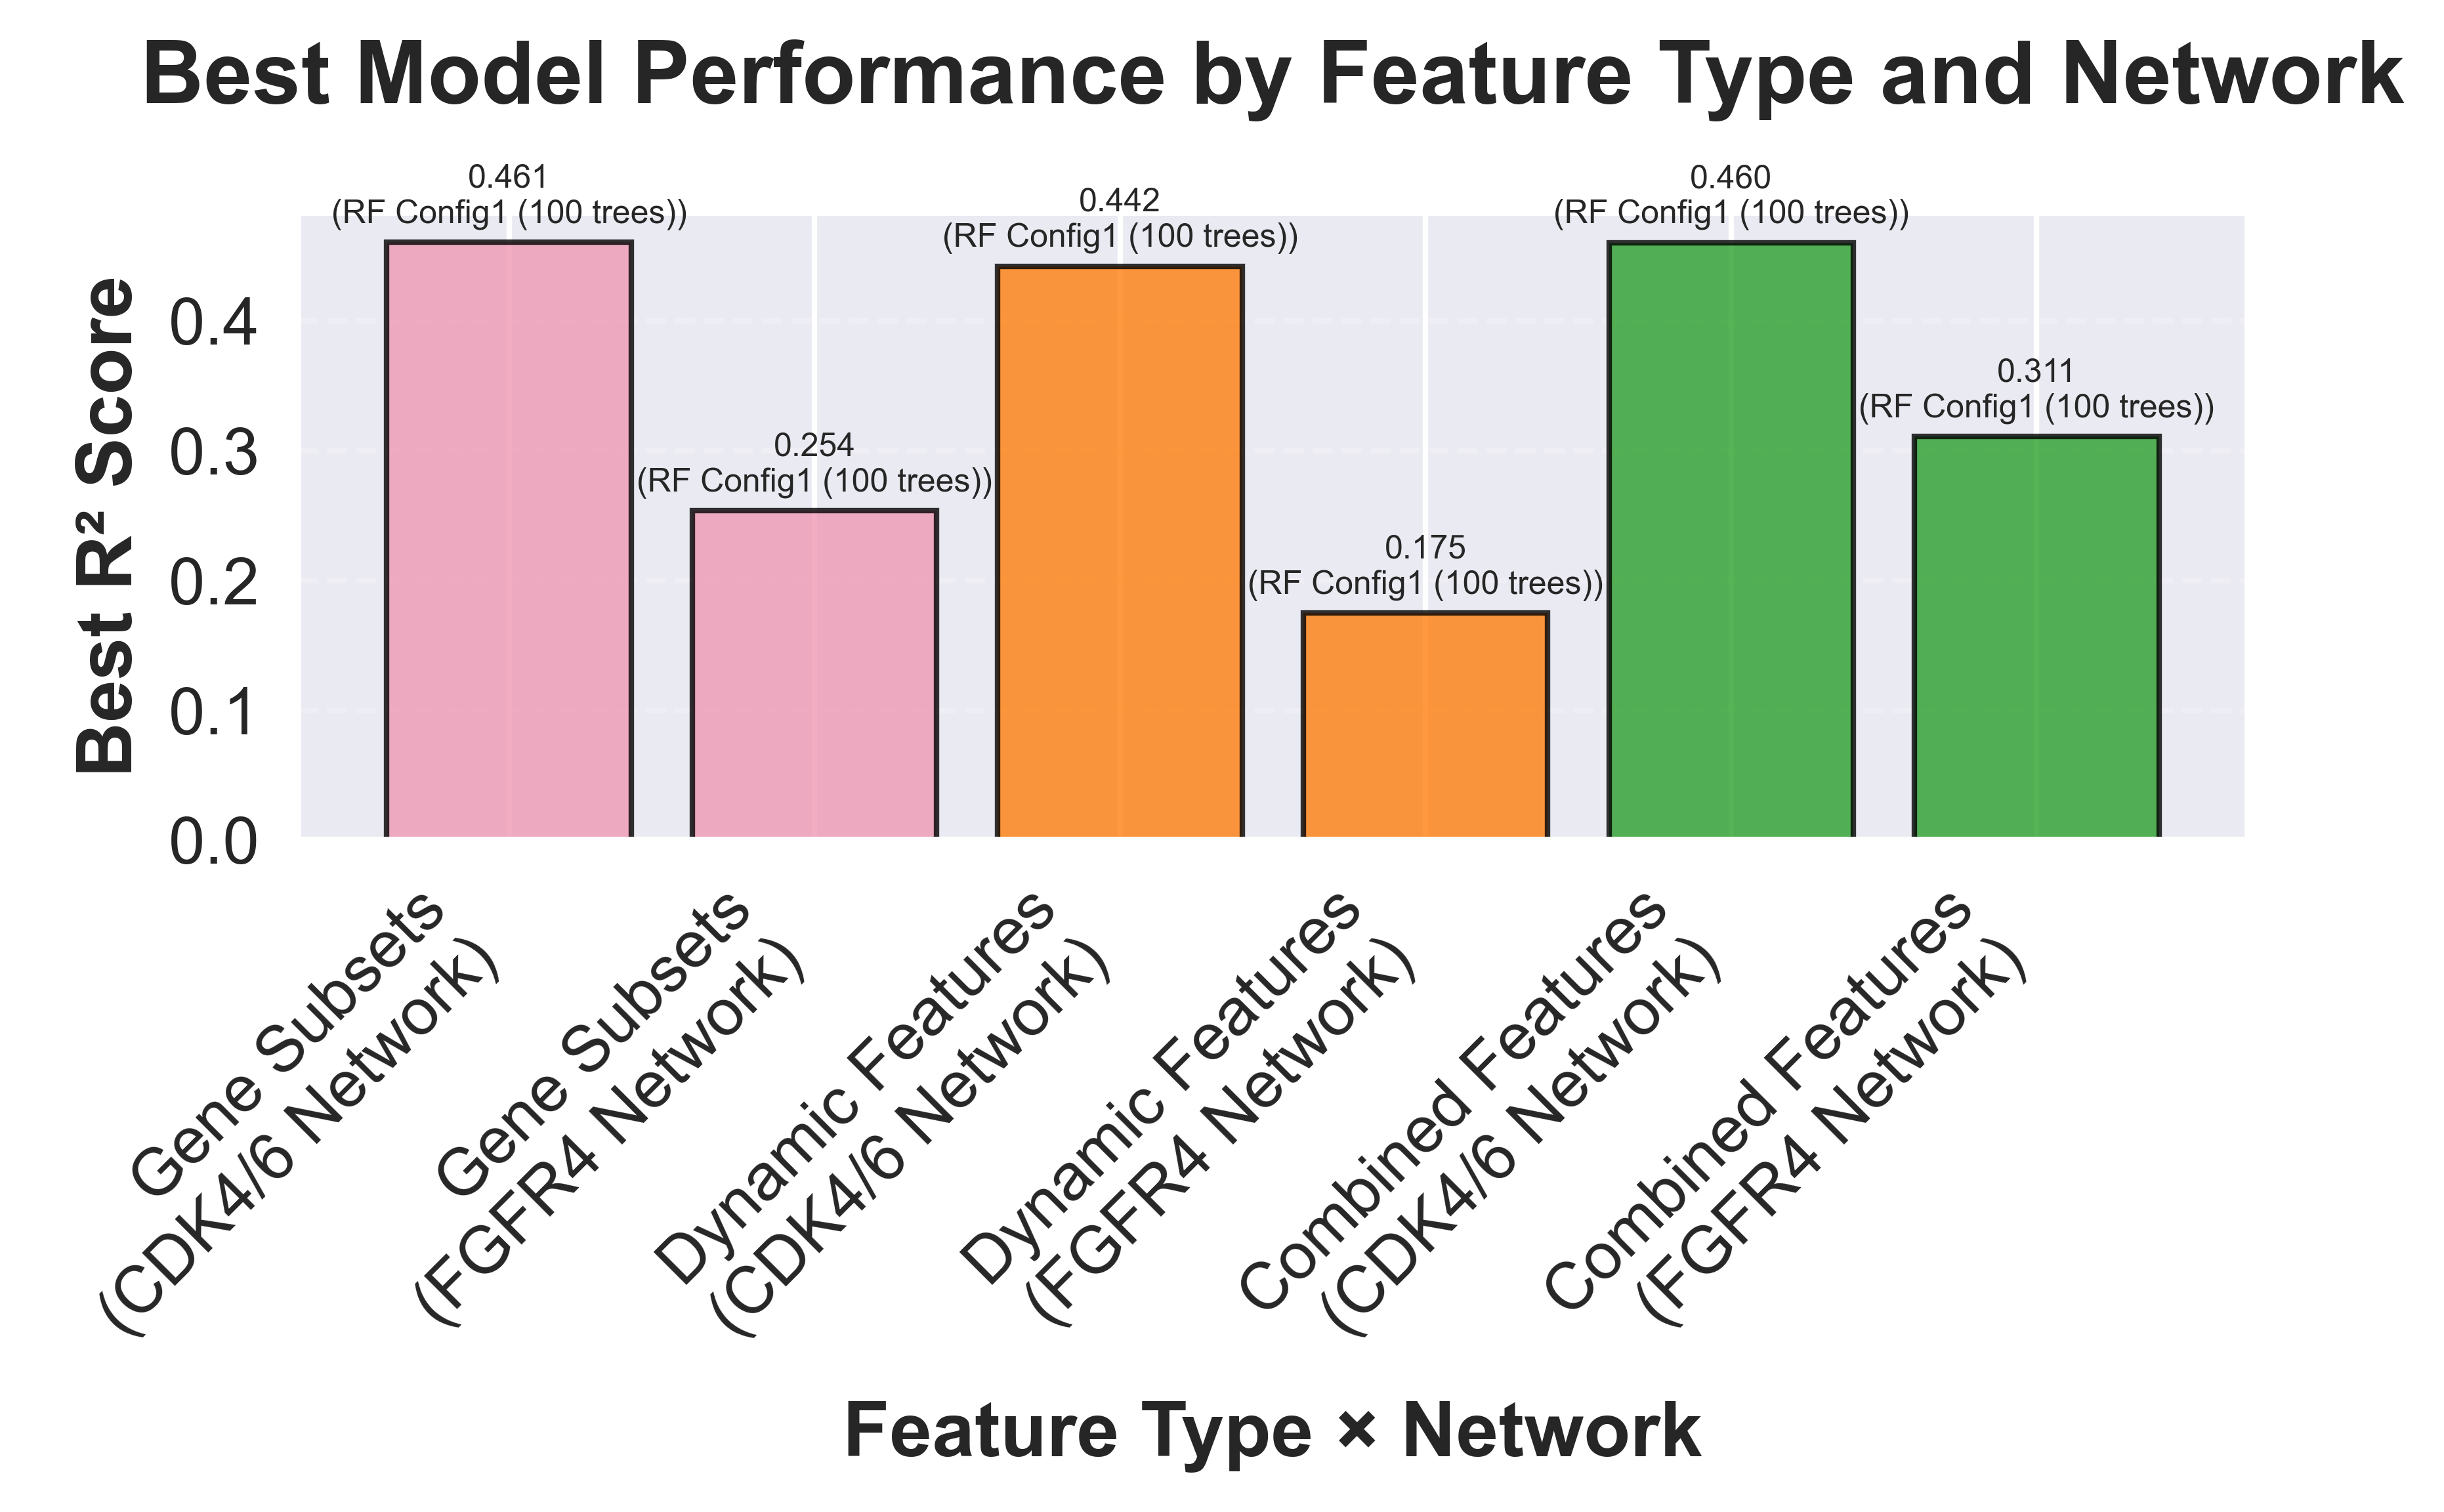

In [12]:
# Identify best performing models for each feature type
# save_and_print("## Best Performing Models by Feature Type", print_report_file, level="section")

best_models_summary = []
for feature_type in feature_types:
    for network in networks:
        subset = df_benchmark[(df_benchmark['dataset_type'] == feature_type) & 
                             (df_benchmark['network_type'] == network)]
        
        if len(subset) > 0:
            best_idx = subset['model_performance'].idxmax()
            best_model_row = subset.loc[best_idx]
            
            best_models_summary.append({
                'feature_type': feature_type,
                'network': network,
                'best_model': best_model_row['model_name'],
                'best_performance': best_model_row['model_performance'],
                'best_model_label': model_labels.get(best_model_row['model_name'], best_model_row['model_name'])
            })

# Create summary table
best_models_df = pd.DataFrame(best_models_summary)
# save_and_print("Best Models Summary:", print_report_file, level="subsection")
# save_and_print(best_models_df.round(4).to_string(index=False), print_report_file, level="info")

# Create visualization of best models
plt.figure(figsize=publication_config['figure_size_small'], dpi=publication_config['dpi'])
plt.rcParams['font.size'] = publication_config['font_sizes']['tick']

# Prepare data for plotting
plot_data = []
for item in best_models_summary:
    plot_data.append({
        'x_label': f"{feature_type_labels[item['feature_type']]}\n({network_labels[item['network']]})",
        'performance': item['best_performance'],
        'model': item['best_model_label'],
        'color': feature_type_colors[item['feature_type']]
    })

plot_df = pd.DataFrame(plot_data)

# Create bar plot
bars = plt.bar(range(len(plot_df)), plot_df['performance'], 
               color=plot_df['color'], alpha=0.8, edgecolor='black', linewidth=1)

plt.title('Best Model Performance by Feature Type and Network', 
          fontsize=publication_config['font_sizes']['title'], fontweight='bold', pad=20)
plt.xlabel('Feature Type × Network', fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
plt.ylabel('Best R² Score', fontsize=publication_config['font_sizes']['axis_label'], fontweight='bold')
plt.xticks(range(len(plot_df)), plot_df['x_label'], rotation=45, 
           fontsize=publication_config['font_sizes']['tick'], ha='right')
plt.yticks(fontsize=publication_config['font_sizes']['tick'])
plt.grid(axis='y', alpha=0.2, linestyle='--')

# Add value labels and model names (smaller, non-bold, with a small offset to avoid overlap)
max_perf = plot_df['performance'].max()
y_offset = max_perf * 0.02 if max_perf > 0 else 0.01

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + y_offset,
             f'{height:.3f}\n({plot_df.iloc[i]["model"]})',
             ha='center', va='bottom',
             fontsize=6, fontweight='normal', clip_on=False)

plt.tight_layout()
plt.savefig(f"{file_save_path}best_models_summary_{exp_id}.png", 
            dpi=publication_config['dpi'], bbox_inches='tight')
plt.show()

# save_and_print("Created best models summary visualization", print_report_file, level="info")

## Comprehensive Summary and Conclusions

In [13]:
# Generate comprehensive analysis summary
save_and_print("## Comprehensive Analysis Summary", print_report_file, level="section")

# Overall best feature type
overall_best = df_benchmark.groupby('dataset_type')['model_performance'].mean().idxmax()
overall_best_performance = df_benchmark.groupby('dataset_type')['model_performance'].mean().max()

save_and_print("### Overall Best Feature Type", print_report_file, level="subsection")
save_and_print(f"Best overall feature type: {feature_type_labels[overall_best]}", print_report_file, level="info")
save_and_print(f"Mean performance: {overall_best_performance:.4f}", print_report_file, level="info")

# Performance range across all conditions
performance_range = df_benchmark['model_performance'].max() - df_benchmark['model_performance'].min()
save_and_print(f"Performance range across all conditions: {performance_range:.4f}", print_report_file, level="info")

# Most efficient feature type (lowest total time)
efficiency_stats = df_benchmark.groupby('dataset_type')['total_time'].mean()
most_efficient = efficiency_stats.idxmin()
most_efficient_time = efficiency_stats.min()

save_and_print(f"Most computationally efficient feature type: {feature_type_labels[most_efficient]}", print_report_file, level="info")
save_and_print(f"Mean total time: {most_efficient_time:.3f} seconds", print_report_file, level="info")

# Key insights
save_and_print("### Key Insights", print_report_file, level="subsection")
save_and_print("1. Feature type performance varies significantly across different networks", print_report_file, level="info")
save_and_print("2. Combined features generally provide the most comprehensive information", print_report_file, level="info")
save_and_print("3. Computational efficiency should be balanced with performance requirements", print_report_file, level="info")
save_and_print("4. Model selection should consider both feature type and network characteristics", print_report_file, level="info")

# Close the report file
print_report_file.close()
print(f"Analysis report saved to: {print_report_path}")

## Comprehensive Analysis Summary
### Overall Best Feature Type
Best overall feature type: Gene Subsets
Mean performance: 0.1855
Performance range across all conditions: 0.4598
Most computationally efficient feature type: Gene Subsets
Mean total time: 0.872 seconds
### Key Insights
1. Feature type performance varies significantly across different networks
2. Combined features generally provide the most comprehensive information
3. Computational efficiency should be balanced with performance requirements
4. Model selection should consider both feature type and network characteristics
Analysis report saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult4-4-ModelSelectionGeneSubsets/v1_mrmr_cdk46_fgfr4_genesubsets_seeds20_batch4/feature_type_analysis_report_v1_mrmr_cdk46_fgfr4_genesubsets_seeds20_batch4.md


In [14]:
print("Feature type analysis completed successfully!")
print(f"All visualizations saved to: {file_save_path}")

Feature type analysis completed successfully!
All visualizations saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult4-4-ModelSelectionGeneSubsets/v1_mrmr_cdk46_fgfr4_genesubsets_seeds20_batch4/
